In [1]:
import numpy as np
import numpy.random as npr
import pandas as pd
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

BOLD = '\033[1m'
END = '\033[0m'
npr.seed(123)

1\. **Radioactive decay chain**

${\rm Tl}^{208}$ decays to ${\rm Pb}^{208}$ with a half-lieve of 3.052 minutes. Suppose to start with a sample of 1000 Thallium atoms and 0 of Lead atoms.

* Take steps in time of 1 second and at each time-step decide whether each Tl atom has decayed or not, accordingly to the probability $p(t)=1-2^{-t/\tau}$. Subtract the total number of Tl atoms that decayed at each step from the Tl sample and add them to the Lead one. Plot the evolution of the two sets as a function of time  
* Repeat the exercise by means of the inverse transform method: draw 1000 random numbers from the non-uniform probability distribution $p(t)=2^{-t/\tau}\frac{\ln 2}{\tau}$ to represent the times of decay of the 1000 Tl atoms. Make a plot showing the number of atoms that have not decayed as a function of time

In [2]:
tau = 3.052*60
N = 1000
time = range(2001)

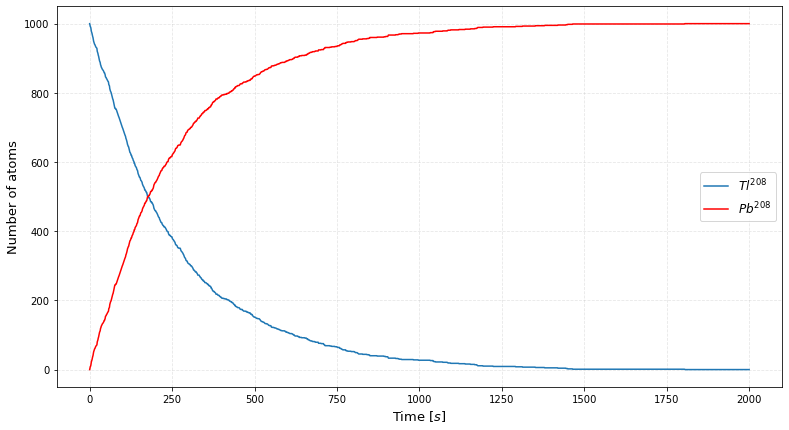

In [3]:
def decay_pdf(step):
    return 1 - np.power(2, -step/tau)

decision = npr.random(N)
Tl = np.array([(decay_pdf(t) < decision).sum() for t in time])
Pb = 1000 - Tl

fig, ax = plt.subplots(figsize = (13, 7))
ax.plot(time, Tl, label = "$Tl^{208}$")
ax.plot(time, Pb, "r", label = "$Pb^{208}$")
ax.set_xlabel("Time $[s]$", fontsize = 13)
ax.set_ylabel("Number of atoms", fontsize = 13)
ax.grid(linestyle = '--', alpha = 0.3)
ax.legend(prop = {"size": 12})
plt.show()

In order to apply the inverse transform method we firstly have to compute the cumulative probability function of $p(t)$ ( where we identify the stochastic variable $t$ with the time, so then $t\geq 0$ ) :
$$
1-2^{-\frac{t}{\tau}} = \int_{0}^{t(z)} p(t') dt' = \int_{0}^{t(z)} 2^{-\frac{t'}{\tau}} \frac{\ln2}{\tau} dt' = \int_0^z dz'= z 
$$

and finally make explicit $t(z)$:
$$
t(z) = -\tau\log_2{(1-z)}
$$

where z is distributed according to an uniform distribution:

$$
\left\{
\begin{array}{ll}
      1 & 0\leq z\leq 1 \\
      0 & {\rm elsewhere}
\end{array} 
\right.
$$

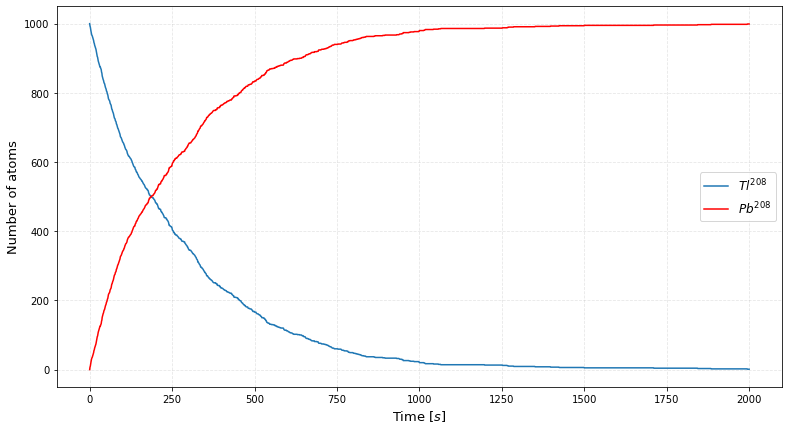

In [4]:
z = npr.random(N)
t = -tau*np.log2(1-z)

Tl = np.array([(t > step).sum() for step in time])
Pb = 1000 - Tl

fig, ax = plt.subplots(figsize = (13, 7))
ax.plot(time, Tl, label = "$Tl^{208}$")
ax.plot(time, Pb, "r", label = "$Pb^{208}$")
ax.set_xlabel("Time $[s]$", fontsize = 13)
ax.set_ylabel("Number of atoms", fontsize = 13)
ax.grid(linestyle = '--', alpha = 0.3)
ax.legend(prop = {"size": 12})
plt.show()

2\. **Rutherford Scattering**

The scattering angle $\theta$ of $\alpha$ particles hitting a positively charged nucleus of a Gold atom ($Z=79$) follows the rule:

$$
\tan{\frac{1}{2} \theta} = \frac{Z e^2} {2\pi \epsilon_0 E b}
$$

where $E=7.7$ MeV and $b$ beam is the impact parameter. The beam is represented by a 2D gaussian distribution with $\sigma=a_0/100$ for both coordinates ($a_0$ being the Bohr radius). Assume 1 million $\alpha$ particles are shot on the gold atom.

Computing the fraction of particles that "bounce back",i.e. those particle whose scattering angle is greater than $\pi/2$ (which set a condition on the impact parameter $b$)

In [26]:
Z = 79
E = 7.7e6              # eV
e = 1.602e-19          # coulomb
E = 7.7e6*e            # N*m = joule
eps0 = 8.854e-12       # F/m = C^2/(N*m^2)
a0 = 5.29e-11          # m
sig = a0/100

N = 1000000

**Scipy.stats.multivariate_normal Sampling**

In [32]:
gauss = stats.multivariate_normal(mean = [0,0], cov = np.identity(2)*sig**2)
rnd_gauss = gauss.rvs(N)
b = np.linalg.norm(rnd_gauss, axis = 1)
theta = 2*np.arctan((Z*e**2)/(2*np.pi*eps0*E*b))

N_bounce = theta[theta > np.pi/2].size
print(BOLD + "\nNumber of particles that 'bounce back' " + END + "=> {0:d}".format(N_bounce))
print(BOLD + "\nFraction of particles that 'bounce back' " + END + "=> {0:.6f}".format(N_bounce/N))
print("\n\n")


Number of particles that 'bounce back' => 1570

Fraction of particles that 'bounce back' => 0.001570





**Box-Muller Sampling**

In [31]:
z = np.random.random(N)
b_squared = -2*(sig**2)*np.log(1-z)
b = np.sqrt(b_squared)
theta = 2*np.arctan((Z*e**2)/(2*np.pi*eps0*E*b))

N_bounce = theta[theta > np.pi/2].size
print(BOLD + "\nNumber of particles that 'bounce back' " + END + "=> {0:d}".format(N_bounce))
print(BOLD + "\nFraction of particles that 'bounce back' " + END + "=> {0:.6f}".format(N_bounce/N))
print("\n\n")


Number of particles that 'bounce back' => 1594

Fraction of particles that 'bounce back' => 0.001594





3\. **Monte Carlo integration: hit/miss vs mean value method**

Consider the function 

$$f(x) =\sin^2{\frac{1}{x(2-x)}}$$

* Compute the integral of $f(x)$ between 0 and 2 with the hit/miss method. Evaluate the error of your estimate
* Repeat the integral with the mean value method. Evaluate the error and compare it with the previous one

In [38]:
def f(x):
    return (np.sin(1/(x*(2-x))))**2

N = 100000
x = npr.uniform(0, 2, N)

**Hit-miss Method**

Computing the **standard deviation $\sigma_{HM}$ of the hit-miss method :** 
$\newline$ If we sample $N$ points uniformly inside the $A$ region we know that the number of points $N_I$ that fall inside a subregion $I \subseteq A$ is a random variable that follow the binomial distribution. In particular we have:
- $I = \frac{A}{N} \langle N_I \rangle$
- $Var(I) = \frac{A^2}{N^2} Var(N_I) = \frac{A^2}{N^2} Np(1-p) \Rightarrow \sigma_{HM} = A \sqrt{\frac{p(1-p)}{N}}$ where $p = \frac{N_I}{N}$
 

In [47]:
y = npr.random(N)
N_I = (y < f(x)).sum()
I = 2*N_I/N
sig = 2*np.sqrt((N_I*(N-N_I))/(N**3))
        
print(BOLD + "\nValue of the Integral " + END + "=> {0:.3f} \u00B1 {1:.3f}".format(I, sig))


Value of the Integral => 1.450 ± 0.003


**Mean Value Method**

In [49]:
I = (2/N)*f(x).sum()        
sig = 2*np.sqrt(np.var(f(x))/N) 
        
print(BOLD + "\nValue of the Integral " + END + "=> {0:.3f} \u00B1 {1:.3f}".format(I, sig))


Value of the Integral => 1.450 ± 0.002


**Error Comparison - Hit-miss vs. Mean Value Method**
$\newline$We have: 

$$
\sigma_{HitMiss} \simeq 0.0028 > \sigma_{MeanValue} \simeq 0.0017
$$

so then the Monte Carlo integration mean value method reaches a better accuracy than the hit-miss method in this case.

4\. **Monte Carlo integration in high dimension**

* Start of by computing the area of a circle of unit radius, by integrating the function 

$$
f(x,y)=
\left\{
\begin{array}{ll}
      1 & x^2+y^2\le 1 \\
      0 & {\rm elsewhere}
\end{array} 
\right.
$$

* Generalize the result for a 10D sphere



**Circle of Unit Radius**

In [22]:
def f(x, y):
    return x**2 + y**2

N = 100000
x = npr.uniform(-1, 1, N)
y = npr.uniform(-1, 1, N)
I = 4/N*(f(x, y) <= 1).sum()

print(BOLD + "\nArea of a circle of unit radius (π)" + END +" => %.4f" %I)
print("\n\n")


Area of a circle of unit radius (π) => 3.1414





**10-Dimensional Sphere**

In [14]:
def SphereVolume(d, r, n):
    point = npr.uniform(-r, r, (n, d))
    dist = np.linalg.norm(point, axis = 1)
    I = ((2*r)**d)/n*(dist <= r).sum()
    return I


N = 100000
dim = 10
radius = 1
Vol = SphereVolume(dim, radius, N)
print(BOLD + "\nVolume of a {0}-dimensional sphere of {1} radius ".format(dim, radius) + END +" => {:.4f}".format(Vol))
print("\n\n")


Volume of a 10-dimensional sphere of 1 radius  => 2.4269





5\. **Monte Carlo integration with importance sampling** 

Calculate the value of the integral:

$$
I=\int_0^1 \frac{x^{-1/2}}{e^x+1} dx
$$

using the importance sampling method with $w(x)=1/\sqrt{x}$. You should get a result about 0.84

**Computing the integral - Simplifications**
$\newline$ Notice that in this case: $$f(x)=\frac{\omega(x)}{e^x+1}$$ So we have: $$I = \frac{1}{N}\sum_{i=1}^N \frac{f(x_i)}{w(x_i)}\int_0^1 w(x)dx = \frac{2}{N\sum_{i=1}^N (e^{x_i}+1)} \simeq 0.84$$ where $$\int_0^1 w(x)dx = \int_0^1 x^{-1/2} dx =2$$

In [17]:
def f(x):
    return np.exp(x)+1
    
N = 10000
y = stats.powerlaw(0.5).rvs(N)

I = 2/N * np.sum(1./f(y))
print(BOLD + "\nValue of the Integral " + END + "=> I = {:.3f}".format(I))
print()


Value of the Integral => I = 0.841

